In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#The First file is the data from the saved webpage containing Lambert Coordinates. This one is taken
#from http://sonlite.dnr.state.la.us/sundown/cart_prod/cart_con_wellinflam1
#Second file is the data downloaded from another part of the database that is contained in:
# http://sonlite.dnr.state.la.us/pls/apex/f?p=108:2216:14519886622333::NO:2216::::
#the latititude and longitude and the databases can be joined using well serial number as key.
#Alternatively, the first database can be downloaded from another query method where the webpage data
#should be copied and pasted into Excel (above code).

AllWellsDF = pd.read_html('DatabaseWellStat.mhtml')[0]
AltWellsDF = pd.read_csv('DatabaseLatLong.csv')

/Users/babakakbari/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,2,4,5,6,8,9,10,13,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/babakakbari/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1]:
AltWellsDF.columns

NameError: name 'AltWellsDF' is not defined

In [11]:
#Set column labels to the first row and then drop that row.
AllWellsDF.columns=AllWellsDF.iloc[0,:]
AllWellsDF =  AllWellsDF.drop(0)

In [12]:
#AllWellsDF.drop_duplicates(keep = 'last', inplace = True)

#If there are duplicates in the HTML database (Lambert coordinates may be reported multiple times)
#then keep last record and drop the rest.

for index , value in AllWellsDF.groupby(["Serial Num"])["Serial Num"].count().iteritems():
    if value > 1:
        x.drop(x.loc[x["Serial Num"] == index].index[:-1], inplace = True)
        print("Dropping all well serial# {} duplicates except last".format(index))

In [13]:
#This part is not used in the current plots. It is for future use when another layer of
#usable water depth is to be used as another layer to the data.
AllWellsDF["Source Area USDW Value"] = pd.to_numeric(AllWellsDF["Source Area USDW Value"],errors='coerce')
for index, row in AllWellsDF.iterrows():
    if row["Source Area USDW Value"] != np.nan:
        if row["Source Area USDW Value"] < 2:
            row["Source Area USDW Value"] = np.nan

In [21]:
AllWellsDF["Serial Num"] = pd.to_numeric(AllWellsDF["Serial Num"],errors='coerce')
AllWellsDF["Well Status"] = pd.to_numeric(AllWellsDF["Well Status"],errors='coerce')

In [22]:
#Dictionary for generic states of different given their status code.
#Description for status code is available on the databse website.
WellCategory = {'DRL' : (1, 2, 3), 'INJ' : (9, 46, 49), 'PRD' : (0, 11, 21, 24, 64, 73), 
               'SHT' : (8, 18, 19, 20, 23, 26, 27, 28, 31, 32, 33, 34, 36, 37), 
               'PNA' : (29, 30, 35, 90), 'GTM' : (74), 'OTR' : (13, 16, 17, 22, 25, 78, 80, 82, np.nan),
               'BAD' : (98, 99, 'ZZZZZ')}

In [24]:
#Drop all wells that are coded as bad data in the databse.
criterion = AllWellsDF['Well Status'].map(lambda x: x in WellCategory['BAD'])
AllWellsDF.drop(AllWellsDF[criterion].index, inplace=True)

In [25]:
#Merge the two databases using the key of well serial number. The purpose is to have the
#latitude,logitude data that are missing from the main databse imported from the alternative one.
AllWellsDF = AllWellsDF.merge(AltWellsDF[['Well Serial Num','Latitude','Longitude']],left_on='Serial Num',
                right_on='Well Serial Num', left_index=True)

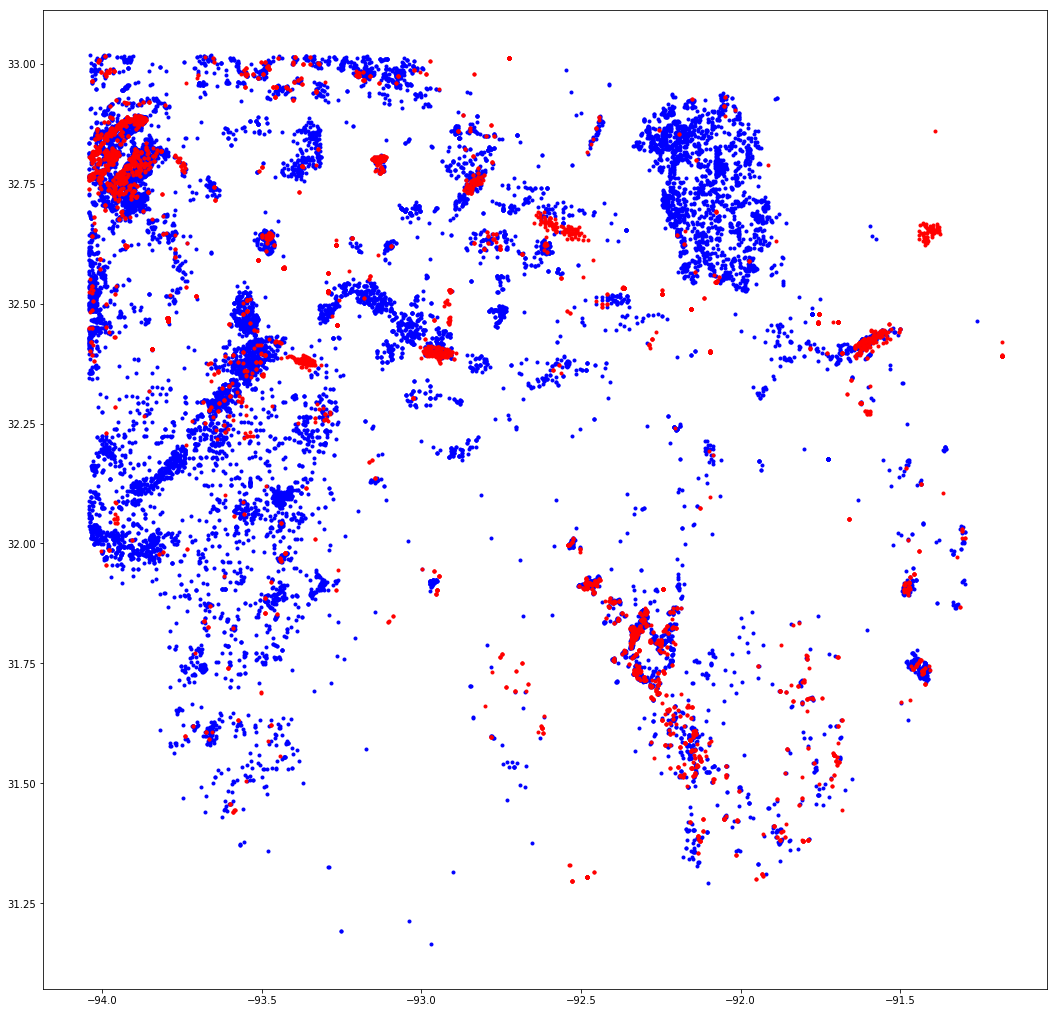

In [36]:
#Plot all the active injection and all the other wells that are potentials leak paths,
#on the latitude,longitude map. Injection wells are plotted using red dots.
#This can be overlaid on an actual map using a Google Maps API (to be done later).
plt.figure(figsize=(18,18))
criterion = AllWellsDF['Well Status'].map(lambda x: x in WellCategory['DRL']+WellCategory['SHT'] )
plt.plot(AllWellsDF[criterion]['Longitude'],AllWellsDF[criterion]['Latitude'],'b.')
criterion = AllWellsDF['Well Status'].map(lambda x: x in WellCategory['INJ'] )
plt.plot(AllWellsDF[criterion]['Longitude'],AllWellsDF[criterion]['Latitude'],'r.')

plt.show()

In [28]:
#Save the two sets of wells and their information to csv file for further processing later.

criterion = AllWellsDF['Well Status'].map(lambda x: x in WellCategory['DRL']+
                                          WellCategory['SHT'] )
LeakPotDF = AllWellsDF[criterion].copy()
LeakPotDF['Leak Risk'] = np.nan
criterion = AllWellsDF['Well Status'].map(lambda x: x in WellCategory['INJ'] )
ActInjDF = AllWellsDF[criterion]

LeakPotDF.to_csv('LeakPot.csv')
ActInjDF.to_csv('ActInj.csv')